# RECONOCIMIENTO DE EXPRESIONES FACIALES 

Librerias 

In [3]:
pip install opencv-python


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.8 MB 1.2 MB/s eta 0:00:34
    --------------------------------------- 0.5/38.8 MB 3.5 MB/s eta 0:00:11
   - -------------------------------------- 1.2/38.8 MB 6.1 MB/s eta 0:00:07
   -- ------------------------------------- 2.6/38.8 MB 9.3 MB/s eta 0:00:04
   ---- ----------------------------------- 4.1/38.8 MB 12.3 MB/s eta 0:00:03
   ----- ---------------------------------- 5.7/38.8 MB 15.1 MB/s eta 0:00:03
   ------ --------------------------------- 6.8/38.8 MB 16.0 MB/s eta 0:00:02
   -------- ------------------------------- 8.0/38.8 MB 16.5 MB/s eta 0:00:02
   ----------- ---

In [4]:
pip install opencv-contrib-python


  Obtaining dependency information for opencv-contrib-python from https://files.pythonhosted.org/packages/a7/9e/7110d2c5d543ab03b9581dbb1f8e2429863e44e0c9b4960b766f230c1279/opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/45.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/45.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/45.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/45.5 MB 326.8 kB/s eta 0:02:20
   ---------------------------------------- 0.2/45.5 MB 1.2 MB/s eta 0:00:40
    --------------------------------------- 0.8/45.5 MB 4.1 MB/s eta 0:00:11
   - -------------------------------------- 1.8/45.5 MB 7.0 MB/s eta 0:00:07
   -- ------------------------------------- 2.8/45.5 MB 9.3 MB/s eta 0:00:05
   --- ------------------------------------ 3.6/45.5 MB 10.5 MB/s eta 0:00:04
   --- ------------------------------------ 4.5/45.5 MB 11.4 MB/s eta 0:00:04
   ----- 

In [2]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import random

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

ModuleNotFoundError: No module named 'cv2'

Cargar dataset 

In [2]:
# Definir carpeta datos y tamaña imagenes
TRAIN_DIR = './data/images/train/'
TEST_DIR = './data/images/test/'
IMG_SIZE = 48
BATCH_SIZE = 32

In [3]:
# Función para cargar y preprocesar imágenes
def preprocess_image(file_path):
    # Carga de la imagen en escala de grises y redimensionamiento
    img = load_img(file_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
    # Convertir imagen a matriz numpy y normalizar píxeles
    img_array = img_to_array(img) / 255.0
    return img_array

In [4]:
def preprocess_image(file_path):
    # Aquí coloca tu código de preprocesamiento de imágenes
    img = cv2.imread(file_path)
    img = cv2.resize(img, (224, 224))  # Asegúrate de ajustar las dimensiones según sea necesario
    return img

def load_data(directory):
    X = []
    filenames = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
           # print(f'Intentando cargar archivo: {file_path}')
            try:
                if os.path.isfile(file_path):  # Asegúrate de que es un archivo y no un directorio
                    img = preprocess_image(file_path)
                    X.append(img)
                    filenames.append(file)
            except Exception as e:
                print(f'Error al cargar {file_path}: {e}')
                
    return np.array(X), filenames

# Verifica si las rutas existen
if not os.path.exists(TRAIN_DIR):
    print(f"Directorio no encontrado: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    print(f"Directorio no encontrado: {TEST_DIR}")

# Cargar datos de entrenamiento y prueba
X_train, train_filenames = load_data(TRAIN_DIR)
X_test, test_filenames = load_data(TEST_DIR)

print(f'Número de imágenes de entrenamiento: {len(X_train)}')
print(f'Número de imágenes de prueba: {len(X_test)}')

Número de imágenes de entrenamiento: 28821
Número de imágenes de prueba: 7066


In [ ]:
IM_SIZE = 224
BATCH_SIZE = 32

TRAIN_PATH = './data/images/train/'

file_names = []
categories = []
filepaths = []

for folder in os.listdir(TRAIN_PATH):
    category = folder
    folder_path = os.path.join(TRAIN_PATH, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_names.append(file)
            categories.append(category)
            filepaths.append(os.path.join(folder_path, file))

df = pd.DataFrame({
    'filenames': file_names,
    'category': categories,
    'filepath': filepaths
})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validate_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='category',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validate_generator = validate_datagen.flow_from_dataframe(
    validate_df,
    x_col='filepath',
    y_col='category',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 23056 validated image filenames belonging to 7 classes.
Found 5765 validated image filenames belonging to 7 classes.


Visualizacion y normalizacion 

In [ ]:
# Funcion mostrar imagenes 
def plot_images(images, labels, rows = 2, cols = 6):
    fig, axes = plt.subplots(rows, cols, figsize = (16, 8))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img, cmap = 'gray')
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Funcion cargar imagenes aleatorias 
def load_random_images_from_directory(directory, num_images = 10):
    class_folders = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    images = []
    labels = []

# cargar imagenes de cada clase 
    for folder in class_folders:
        class_name = os.path.basename(folder)
        images_files = os.listdir(folder)
        random_files = random.sample(images_files, min(num_images, len(images_files)))

        for file in random_files:
            img_path = os.path.join(folder, file)
            img = load_img(img_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img)
            img_array = img_array / 255
            images.append(img_array)
            labels.append(class_name)

    return images, labels

In [ ]:
train_images, train_labels = load_random_images_from_directory(TRAIN_DIR, num_images = 5)

Imágenes de Entrenamiento:


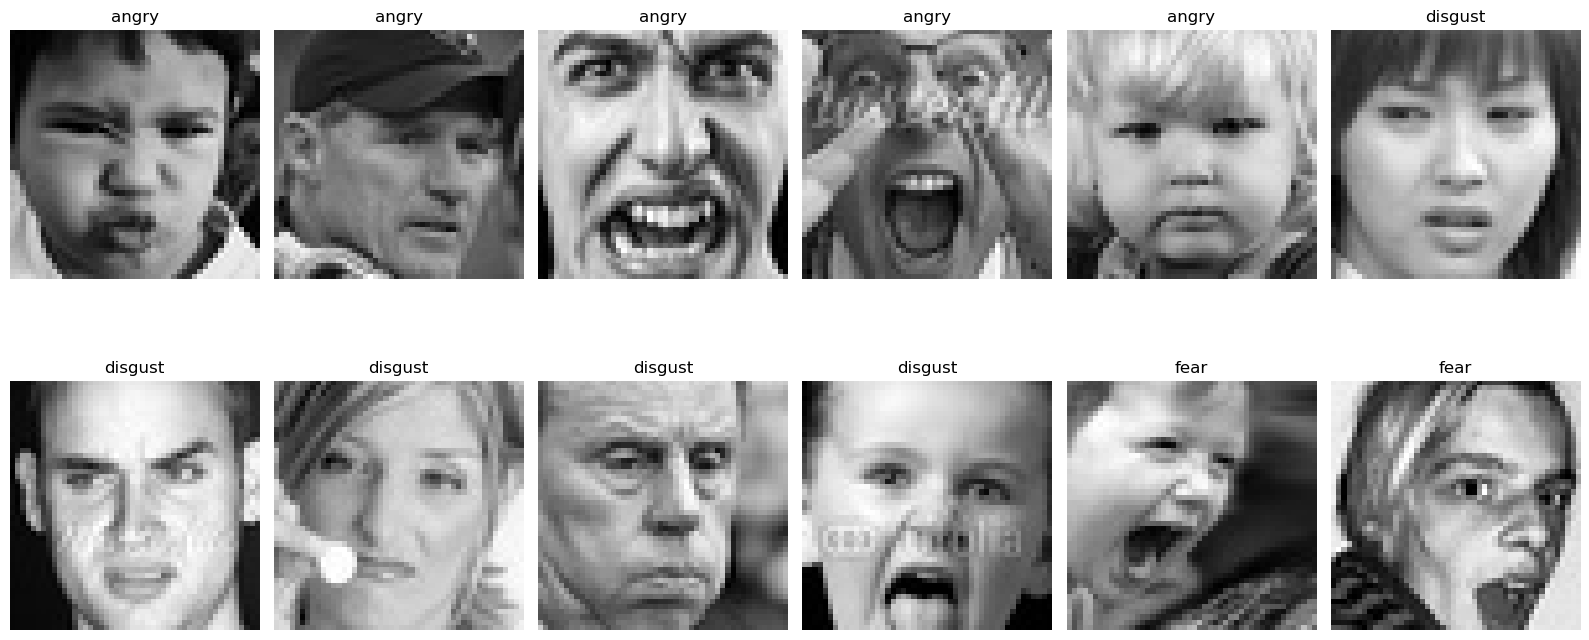

In [ ]:
print("Imágenes de Entrenamiento:")
plot_images(train_images, train_labels)

Preprocesamiento de imagenes

In [ ]:
# Definir generador datos con aumentacion
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 10, 
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1, 
    horizontal_flip = True, 
    validation_split = 0.2 
)

test_datagen = ImageDataGenerator(rescale= 1/255)

In [ ]:
# Generador imagenes Train
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset = 'training' 
)

Found 23060 images belonging to 7 classes.


In [ ]:
# Generacion imagenes Validation 
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset = 'validation' 
)

Found 5761 images belonging to 7 classes.


In [ ]:
# Generacion imagenes Test 
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    shuffle = False 
)

Found 0 images belonging to 1 classes.


In [ ]:






# Definir modelo
model = Sequential()

model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 1))) # Capa explicita (evitar warning)

# 1a capa convolucional/pooling
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))

# 2da capa convolucional/pooling
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))

# 3a capa convolucional/pooling
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))

# Aplanar
model.add(Flatten())

# Capas densas
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

# Capa salida 
model.add(Dense(2, activation = 'softmax'))
# Compilar modelo 
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


NameError: name 'Input' is not defined

CONSTRUCCION RED NEURONAL
- Diseñar RN capas adecuadas
- Configurara parametros para entrenamiento 

ENTRENAMIENTO MODELO
- Entrenar modelo 
- Validar modelo y ajustar hiperparametros 

EVALUACION Y PREDICCION
- Evaluar modelo
- Preparar predicciones 